# Introdução
- Detalhamento do problema e visão geral sobre o funcionamento do programa

O desafio proposto nesse trabalho prático consiste em fazer com que dois robôs móveis com caracteristicas bem definidas se locomoveseem em ambientes que possuiem vários obstáculos, cada robô deverá utilizar um algoritmo de planejamento de caminhos sendo eles roadmap e campos potenciais, sendo eles um algoritmo deliberativo e o outro reativo respectivamente, para partirem de uma posição inicial até a posição objetivo.

Para que o robô consiga realizar essa tarefa é necessário dois componemtes importantissimos um modulo para o planejamento de caminho e outro módulo responsável pelo controle do robô.

Robô holonômico (robotino) + roadmap: Neste notebook primeiro foi feito o planejamento de caminho (roadmap), usando a discretização do mapa e então transformando ele em um grafo e decidindo o menor caminho. Em seguida foi realizado a parte de controle, em que o robô deve se mover para cada aresta decidida no roadmap.

# Implementação

In [57]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

Modulos Usados Nesse trabalho prático



In [58]:
# Other Modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import networkx as nx

## Roadmap
A seguir estão as funções usadas no roadmap. São criadas células (fixas) para o espaço independente dos obstáculos. As célula são marcadas como totalmente ocupadas mesmo se possuirem apenas parte do obstáculo. O caminho encontrdado pelo roadmap é conectividade 4, ou seja, o caminho não conta com deslocamentos na diagonal.

## Visualizar o mapa
Uma função que carrega uma imagem e mostra ela em preto e branco e retorna a matriz numpy correspondente à imagem

In [59]:
def visuMapa(arquivo, threshold):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Lê a imagem do arquivo especificado e inverte as cores (0 para 1 e 1 para 0)
    img = 1 - mpimg.imread(arquivo)

    # Aplica um limiar para binarizar a imagem: valores maiores que o limiar tornam-se 1, e os outros 0
    img[img > threshold] = 1
    img[img<= threshold] = 0

    # Exibe a imagem binarizada no subplot criado, usando uma escala de cinza e com a origem no canto superior esquerdo
    ax.imshow(img, cmap='Greys', origin='upper')

    # Retorna a imagem binarizada
    return img

## Visualizar grid
Função que Discretiza o Ambiente e plota o grid

In [60]:
def visuGrid(img, map_dims, threshold, cell_size):
    # Calcula a escala de pixel/metro
    sy, sx = img.shape / map_dims

    # Calcula o número de linhas e colunas do grid
    rows, cols = (map_dims / cell_size).astype(int)
    grid = np.zeros((rows, cols))

    # Preenche o grid
    # Cada célula recebe o somatório dos valores dos pixels dentro dela
    for r in range(rows):
        for c in range(cols):
            
            xi = int(c*cell_size*sx)
            xf = int(xi + cell_size*sx)
            
            yi = int(r*cell_size*sy)
            yf = int(yi + cell_size*sy)
                        
            grid[r, c] = np.sum(img[yi:yf,xi:xf])
            
    # Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
    grid[grid > threshold] = 1
    grid[grid<= threshold] = 0        

    # Cria uma nova figura
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plota o mapa de pixels como fundo
    obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

    # Adiciona linhas do grid para facilitar a visualização
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

    # Retorna o número de linhas, colunas e o grid binarizado
    return rows, cols, grid

## Visualizar grafo grid
Transforma o grid em um grafo

In [61]:

def grafoGrid(rows, cols, grid, map_dims, cell_size):
    # Criando um grafo de grade com vértices em todas as células
    G = nx.grid_2d_graph(rows, cols) 

    # Removendo células marcadas com obstáculos
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 1:  
                G.remove_node((r,c))

    # Criando uma nova figura
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plotando o grid binarizado
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

    # Adicionando linhas do grid
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

    # Posicionando os vértices no centro das células
    pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}

    # Desenhando o grafo com os vértices
    nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

    # Retorna o grafo e a posição dos vértices
    return G, pos

## Visualizar caminho
Determina o menor caminho entre o ponto de partida do robô e o ponto de chegada

In [62]:
def visuCaminho(grid, map_dims, G, pos, start_node, end_node):
    # Criando uma nova figura
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plotando o mapa binarizado
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

    # Encontrando o menor caminho entre os nós de início e fim
    path = nx.shortest_path(G, source=start_node, target=end_node)

    # Desenhando os nós do caminho como círculos azuis
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

    # Retorna o caminho encontrado
    return path

## Controle Holonômico

## Coppelia
A próxima célula se conecta ao coppelia

In [63]:
clientID = RemoteAPIClient()
sim = clientID.require('sim')
sim.setStepping(True)

0

## Simulação
Esta função controla o movimento do robô ao longo do caminho fornecido, garantindo que ele alcance cada ponto no caminho de forma eficiente e precisa. Nessa função o robô através da cinemática vai sempre para o referencial Goal, que são os pontos do caminho.

In [64]:
def Rz(theta):
    # A função retorna uma matriz de rotação 3x3 em torno do eixo z por um ângulo de theta
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

def simulacao(path):
    # Inicia a simulação no ambiente CoppeliaSim
    sim.startSimulation()
    print ('Connected to remote API server')

    # Nome do robô no ambiente de simulação
    robotname = '/robotino'
    # Obtém o identificador do objeto que representa o robô na simulação
    robotHandle = sim.getObject(robotname)     
    # Obtém o identificador do objeto de referência no ambiente de simulação
    referenceHandle = sim.getObject('/ReferenceFrame')     

    # Obtém os identificadores dos objetos que representam as rodas do robô na simulação
    wheel1 = sim.getObject(robotname+'/wheel0_joint')
    wheel2 = sim.getObject(robotname + '/wheel1_joint')
    wheel3 = sim.getObject(robotname + '/wheel2_joint')
                
    # Constantes cinemáticas do robô
    L = 0.135   # Metros
    r = 0.040   # Metros
                
    # Matriz de transformação para a cinemática direta do robô
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    # Itera sobre cada nó no caminho fornecido
    for node in path:

        # Define a configuração de destino (x, y, theta) para o robô alcançar
        qgoal = np.array([node[0], node[1], np.deg2rad(0)])

        # Define um objeto de referência para representar o objetivo na simulação
        goalFrame = sim.getObject('/Goal')     
        sim.setObjectPosition(goalFrame, [qgoal[0], qgoal[1], 0],referenceHandle )
        sim.setObjectOrientation(goalFrame, [0, 0, qgoal[2]], referenceHandle)

        # Ganho do controlador proporcional
        gain = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])

        # Loop para controlar o robô até que o objetivo seja alcançado
        while True:
            # Obtém a posição e orientação atual do robô na simulação
            pos = sim.getObjectPosition(robotHandle,referenceHandle)        
            ori = sim.getObjectOrientation(robotHandle,referenceHandle)

            # Configuração atual do robô
            q = np.array([pos[0], pos[1], ori[2]])
        
            # Calcula o erro entre a posição e orientação atual do robô e o objetivo
            error = qgoal - q
            
            # Verifica se o robô está dentro de uma margem aceitável de distância do objetivo
            if (np.linalg.norm(error[:2]) < 0.05):
                break

            # Calcula a velocidade desejada do robô usando um controlador proporcional
            qdot = gain @ error
            
            # Calcula os comandos de velocidade das rodas do robô
            Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
            u = Minv @ qdot

            # Define a velocidade alvo para as rodas do robô na simulação
            sim.setJointTargetVelocity(wheel1, u[0])
            sim.setJointTargetVelocity(wheel2, u[1])
            sim.setJointTargetVelocity(wheel3, u[2])  

            sim.step()  

        # Define as velocidades das rodas como zero para parar o robô após alcançar o objetivo
        sim.setJointTargetVelocity(wheel1, 0)
        sim.setJointTargetVelocity(wheel2, 0)
        sim.setJointTargetVelocity(wheel3, 0)
        
    # Finaliza a simulação no ambiente CoppeliaSim
    sim.stopSimulation()
    sim.step()

        
    print ('Program ended')

# Testes

## Teste 1

In [65]:
# valor para binarizar a imagem
threshold = 0.5
# Tamanho das células usadas para dividir o mapa
cell_size = 1
# Nó de início do caminho 
start_node =  (1, 1)
# Nó de fim do caminho
end_node = (20, 20)
# Dimensões do mapa
map_dims = np.array([30, 30])  

### Aqui podemos ver o mapa que foi usado para criar a cena no Coppelia

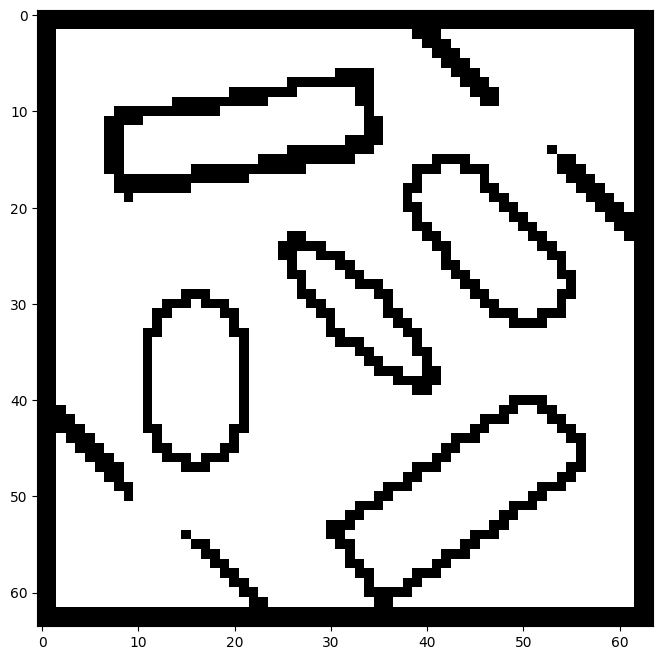

In [66]:
img = visuMapa('mapasSemContorno/map1semContorno.png', threshold)

### Aqui é possível ver o grid do mapa e os obstáculos

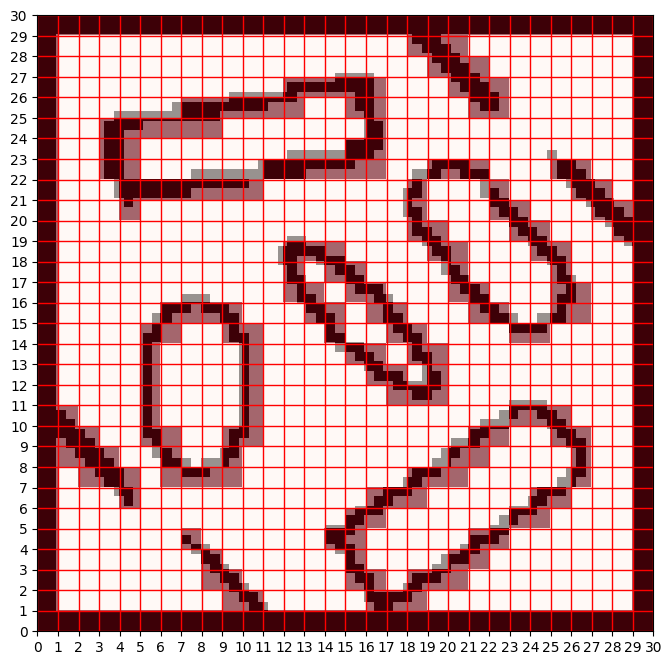

In [67]:
rows, cols, grid, = visuGrid(img, map_dims, threshold, cell_size)

### Aqui é possível ver o grafo com obstaculos gerado a partir do grid

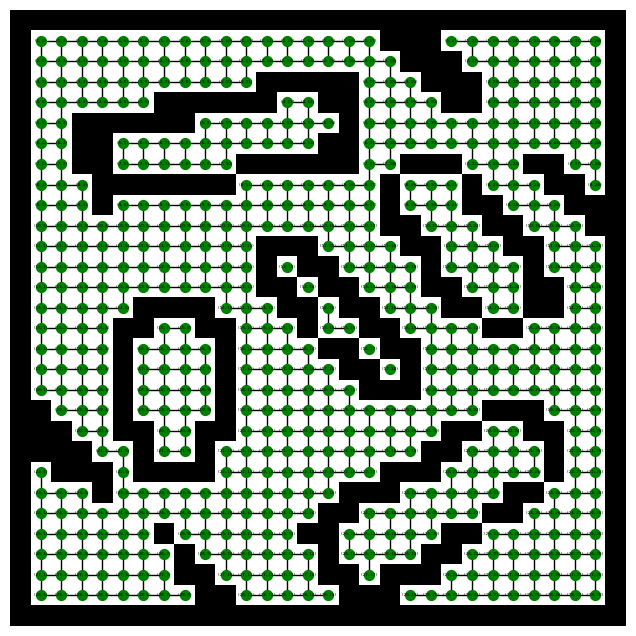

In [68]:
G, pos = grafoGrid(rows, cols, grid, map_dims, cell_size)

### Aqui é possível ver o menor caminho manhatan entre o ponto de inicio escolhido e o ponto de chegada

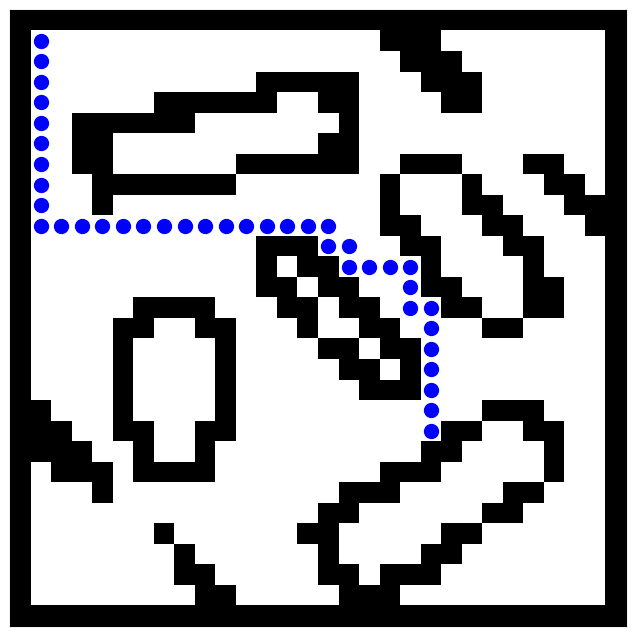

In [69]:
path = visuCaminho(grid, map_dims, G, pos, start_node, end_node)

### Simulação


In [70]:
# caminho e nome do arquivo da cena
current_path = os.getcwd()
scenesFolder = "/scenes/robotino"
scenesFolder = current_path + scenesFolder
selectedScene = "mapa1.ttt"

# abre a cena
sim.loadScene(os.path.join(scenesFolder, selectedScene)+"@keepCurrent")

# roda a simulação
simulacao(path)


Connected to remote API server


Nas simulações, na cena o frame de referência foi colocado próximo ao ponto 0,0 do mapa, o caminho feito pelo robô é mostrado pela linha amarela. Nesse teste, é possível observar pela imagem que o robô foi bem sucedido em seu caminho. No entanto, o robô passa muito próximo de alguns obstáculos.

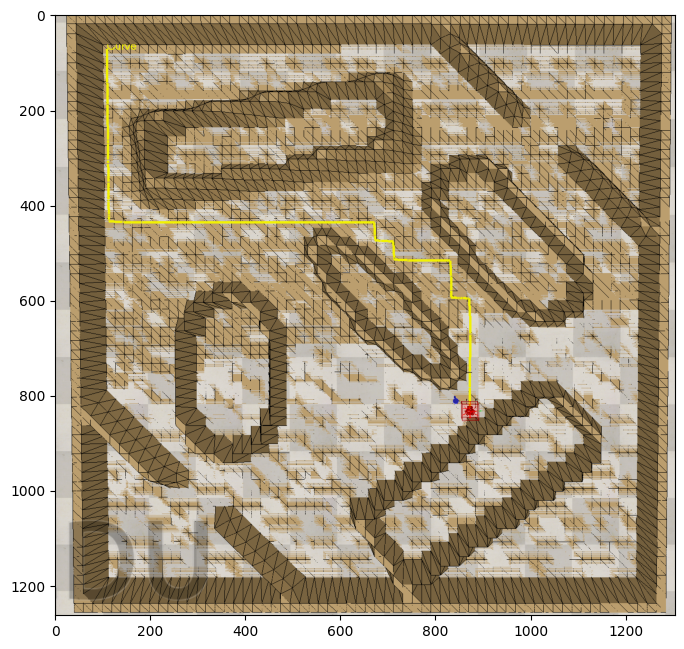

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Lê a imagem do arquivo especificado e plota
img = mpimg.imread('testes/teste1.png')
ax.imshow(img)

## Teste 2
Aqui estão todos os mesmos passos do teste 1

Connected to remote API server


KeyboardInterrupt: 

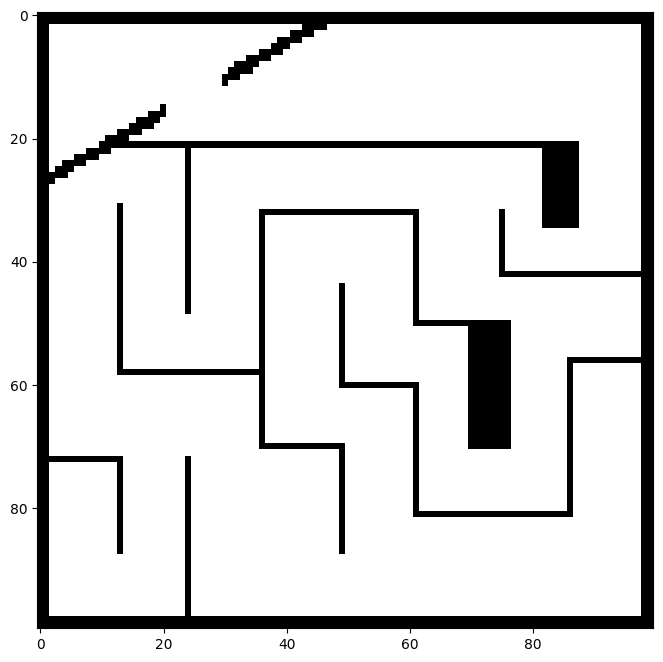

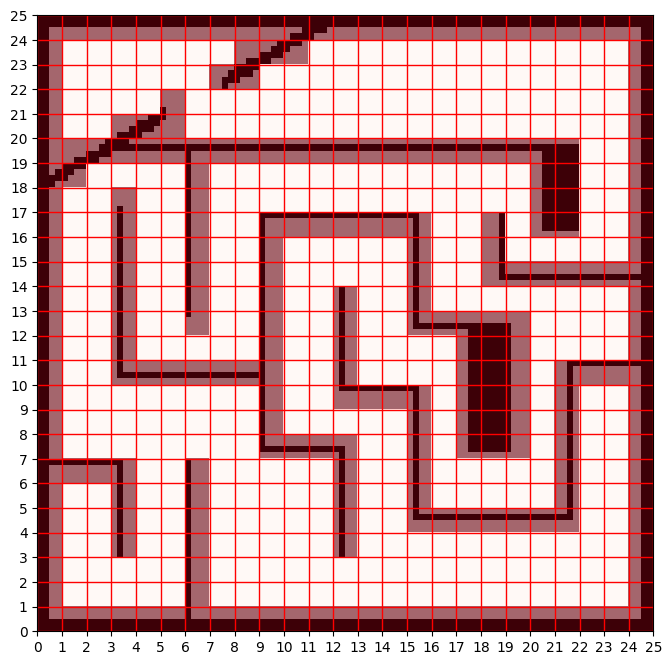

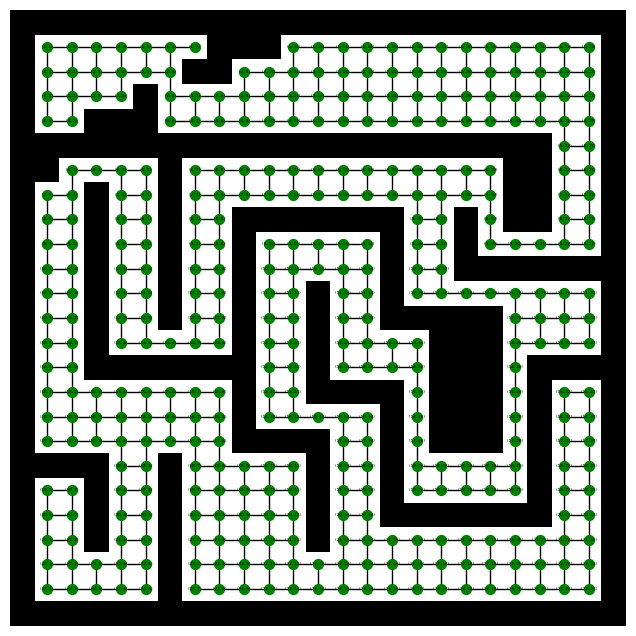

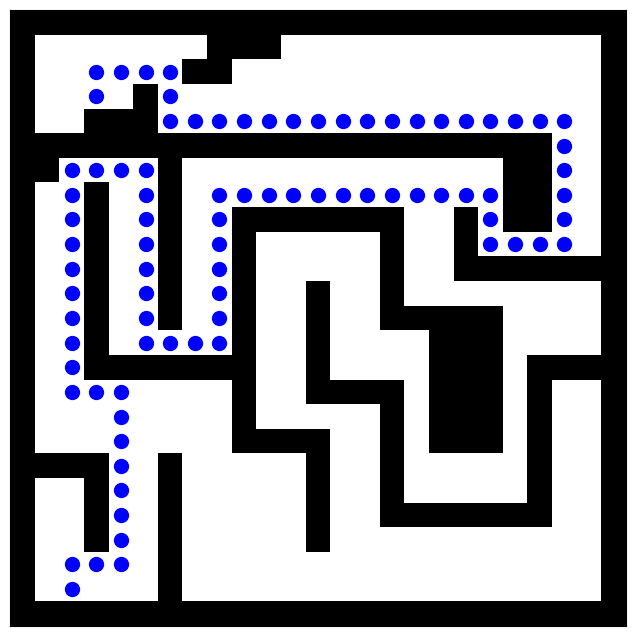

In [ ]:
# valor para binarizar a imagem
threshold = 0.5
# Tamanho das células usadas para dividir o mapa
cell_size = 1
# Nó de início do caminho 
start_node =  (3, 3)
# Nó de fim do caminho
end_node = (23, 2)
# Dimensões do mapa
map_dims = np.array([25, 25])  


img = visuMapa('mapasSemContorno/mapa2semcontorno.png', threshold)
rows, cols, grid, = visuGrid(img, map_dims, threshold, cell_size)
G, pos = grafoGrid(rows, cols, grid, map_dims, cell_size)
path = visuCaminho(grid, map_dims, G, pos, start_node, end_node)

# caminho e nome do arquivo da cena
current_path = os.getcwd()
scenesFolder = "/scenes/robotino"
scenesFolder = current_path + scenesFolder
selectedScene = "mapa2.ttt"

# abre a cena
sim.loadScene(os.path.join(scenesFolder, selectedScene)+"@keepCurrent")

# roda simulação
simulacao(path)


Nesse teste, é possível observar pela imagem que o robô foi bem sucedido em seu caminho. No entanto, o robô passa muito próximo de alguns obstáculos.

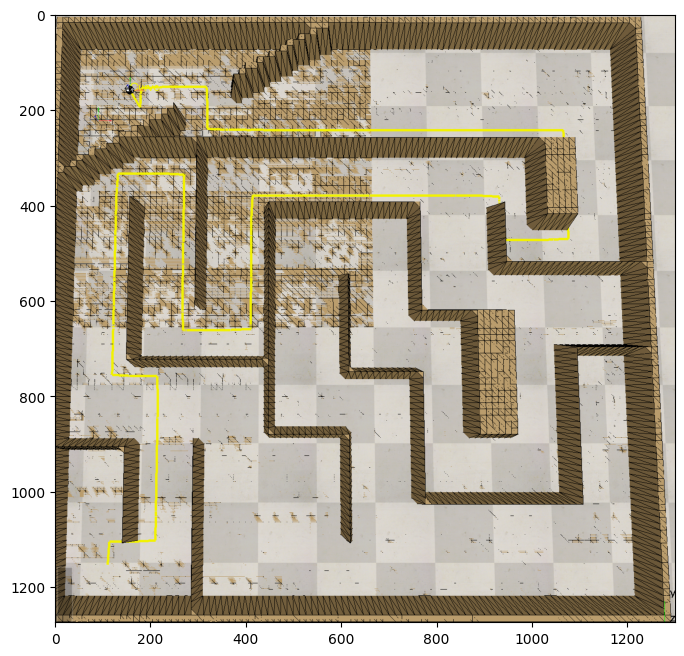

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Lê a imagem do arquivo especificado e plota
img = mpimg.imread('testes/teste2.png')
ax.imshow(img)

# Conclusão
O algoritmo de roadmaps é eficiente e ótimo. Um problema que eu encontrei ao fazer o algoritmo foi que o robô passa muito perto dos obstáculos, o que poderia ser resolvido se nos mapas forem colocados uma margem de erro em volta dos obstáculos. Isso foi tentado, mas por causa da baixa densidade de pixeis dos mapas, muitos caminhos ficaram obstruidos, o que tornou a ideia inviável. 
Também achei o robô um pouco lento, pois ele anda apenas um metro a cada iteração.

# Bibliografia
Vídeo, slides e notebook da aula 09 - Controle Cinemático

Vídeo, slides e notebook da aula 13 - Planejamento de caminhos – Roadmaps